In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset
from transformers import pipeline
import pandas as pd
import json

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Original Dataset and Contrast Set
original_set = pd.read_csv('Dataset/test_original.tsv', sep='\t')
contrast_set = pd.read_csv('Dataset/test_contrast.tsv', sep='\t')

# Load Original Dataset and Contrast Set
prompt_original_set = pd.read_csv('Dataset/dev_original.tsv', sep='\t')
prompt_contrast_set = pd.read_csv('Dataset/dev_contrast.tsv', sep='\t')


# Change Labels from 'Positive' to 1 and from 'Negative' to 0
original_set['Sentiment'] = original_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})
contrast_set['Sentiment'] = contrast_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})
prompt_original_set['Sentiment'] = prompt_original_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})
prompt_contrast_set['Sentiment'] = prompt_contrast_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})


print(original_set.head())
print()
print(contrast_set.head())

   Sentiment                                               Text
0          0  A spoiler.<br /><br />What three words can gua...
1          0  The premise of this awaited sequel was really ...
2          0  The wonderful "Z" Channel in Los Angeles showe...
3          1  Carl Brashear (Cuba Gooding, Jr.) was born to ...
4          1  This slick and gritty film consistently delive...

   Sentiment                                               Text
0          1  A spoiler.<br /><br />What three words can gua...
1          1  The premise of this awaited sequel was really ...
2          1  The wonderful "Z" Channel in Los Angeles showe...
3          0  Carl Brashear (Cuba Gooding, Jr.) was born to ...
4          0  This slick and gritty film consistently fails ...


In [3]:
import random
def build_example(dataset, index):
    return f"""TEXT: {dataset['Text'][index]}
SENTIMENT: {["NEGATIVE", "POSITIVE"][dataset['Sentiment'][index]]}
"""

def get_build_prompt(dataset, shots=1):
    def build_prompt(sent):
        ret = ""
        '''
        if prompt_defintion and shots >0:
            ret += 'Classify the Sentiment of the TEXT. You can only choose between NEGATIVE or POSITIVE. Here you have some examples:\n\n'
        elif prompt_defintion:
            ret += 'Classify the Sentiment of the TEXT. You can only choose between NEGATIVE or POSITIVE:\n'
        '''
        
        indexes = random.sample(range(0, len(dataset)-1), shots)
        for index in indexes:
            ret += build_example(dataset, index)+"\n"
        ret += f"TEXT: {sent}\n"
        ret += "SENTIMENT:"

        return ret
    
    return build_prompt

prompt = get_build_prompt(prompt_contrast_set, shots=3)
print(prompt("This is my sentence"))

TEXT: Johnny and June Carter Cash financed this film which is a traditional rendering of the Gospel stories. The music is great ish, you get a real feel of what the world of Jesus looked like (I've been there too), and June gets into the part of Mary Magdalene with a passion. Cash's narration is good too.<br /><br />But....<br /><br />1. The actor who played Jesus was miscast. 2. There is no edge to the story like Cash puts in some of his faith based music. 3. Because it is uncompelling, I doubt we'll see this ever widely distributed again.<br /><br />I'd never buy the CD.<br /><br />Tom Paine Texas, USA
SENTIMENT: NEGATIVE

TEXT: There's something wonderful about the fact that a movie made in 1934 can be head and shoulders above every Tarzan movie that followed it, including the bloated and boring 1980s piece Greystoke. Unfortunately, it still sucks. hard. Once the viewer gets past the first three scenes, which are admittedly dull, Tarzan and his Mate takes off like a shot, offering n

In [4]:
def inference(*, prompt, sentence, tokenizer, model):
    inputs = tokenizer(prompt(sentence), return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=50)
    output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    if "NEGATIVE" in output:
        return 0
    elif "POSITIVE" in output:
        return 1
    else:
        #print("Model is confused... generated text: ", output)
        return 0

print(inference(prompt=prompt, sentence="I love you", tokenizer=tokenizer, model=model))

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


1


In [5]:
import torch
from tqdm import tqdm
from transformers import pipeline
from sklearn.metrics import classification_report

@torch.no_grad()
def eval(dataset, prompt_dataset):
    overall_results = dict()

    for shots in [0,1,3,5]:
        print("Running shot", shots)
        prompt = get_build_prompt(prompt_dataset, shots=shots)

        total = len(dataset)
        targets = []
        predictions = []

        for i in tqdm(range(total), total=total):
            targets.append(dataset['Sentiment'][i])
            predictions.append(inference(prompt=prompt, sentence=dataset['Text'][i], tokenizer=tokenizer, model=model))
            if i >= total:
                break
    
        report = classification_report(targets, predictions, output_dict=True)
        overall_results[shots] = report

    return overall_results

In [6]:
results_original_set = eval(dataset=original_set, prompt_dataset=prompt_original_set)

with open('origin_results.json', 'w') as f:
    json.dump(results_original_set, f, sort_keys=True, indent=4)

Running shot 0


100%|██████████| 488/488 [03:10<00:00,  2.56it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running shot 1


100%|██████████| 488/488 [02:35<00:00,  3.15it/s]


Running shot 3


100%|██████████| 488/488 [04:18<00:00,  1.89it/s]


Running shot 5


100%|██████████| 488/488 [04:26<00:00,  1.83it/s]


In [7]:
results_contrast_set = eval(dataset=contrast_set, prompt_dataset=prompt_contrast_set)

with open('contrast_results.json', 'w') as f:
    json.dump(results_contrast_set, f, sort_keys=True, indent=4)

Running shot 0


100%|██████████| 488/488 [03:10<00:00,  2.57it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running shot 1


100%|██████████| 488/488 [02:42<00:00,  3.01it/s]


Running shot 3


100%|██████████| 488/488 [04:23<00:00,  1.85it/s]


Running shot 5


100%|██████████| 488/488 [04:29<00:00,  1.81it/s]


In [8]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

performance_original = []
performance_contrast = []

for shot, report in results_original_set.items():
    performance_original.append(dict(shot=shot, accuracy=report["accuracy"]))

for shot, report in results_contrast_set.items():
    performance_contrast.append(dict(shot=shot, accuracy=report["accuracy"]))


In [9]:
total = []
indexes = []
original_result = [performance_original[x]['accuracy'] for x in range(len(performance_original))]
contrast_result = [performance_contrast[x]['accuracy'] for x in range(len(performance_contrast))]
shots_list = [str(x)+' Shots' for x in [y['shot'] for y in performance_contrast]]

for i in range(len(original_result)):
    total.append(original_result[i])
    total.append(contrast_result[i])
    indexes.append(shots_list[i])
    indexes.append(shots_list[i]+' C')

print(total)
print(indexes)

[0.4979508196721312, 0.5020491803278688, 0.5491803278688525, 0.47540983606557374, 0.639344262295082, 0.6454918032786885, 0.5758196721311475, 0.6209016393442623]
['0 Shots', '0 Shots C', '1 Shots', '1 Shots C', '3 Shots', '3 Shots C', '5 Shots', '5 Shots C']


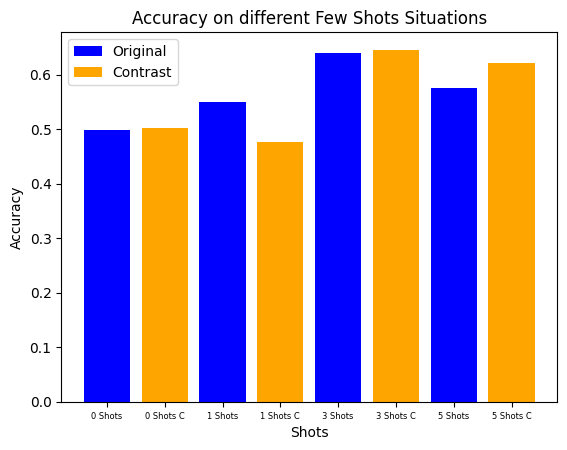

In [10]:
plt.bar([i for i in range(len(indexes)) if i % 2 == 0], [total[i] for i in range(len(indexes)) if i % 2 == 0], color='blue', label='Original')
plt.bar([i for i in range(len(indexes)) if i % 2 != 0], [total[i] for i in range(len(indexes)) if i % 2 != 0], color='orange', label='Contrast')
plt.xticks(ticks = [i for i in range(len(indexes))], labels=[indexes[i] for i in range(len(indexes))], fontsize=6)

plt.ylabel('Accuracy')
plt.xlabel('Shots')

plt.title('Accuracy on different Few Shots Situations')
plt.legend()
plt.show()